# Super Resolution

In this section you are required to implement a model for super resolution task. The general structure is given below. You can use it as a template.

Super Resolution is a self-supervised task where you give input image to a network and try to obtain a higher resolution version of that image.

There are couple of studies you can examine before implementing the model. 


Image Super-Resolution Using Deep Convolutional Networks: https://arxiv.org/abs/1501.00092

Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network: https://arxiv.org/abs/1609.04802

**Model weight link= https://drive.google.com/open?id=1xlpYBD99gBVex71ai1bhS-2ES1DLxbXn**

# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Thu Dec 12 07:56:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 22%   51C    P0    74W / 250W |     96MiB / 12209MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
from torch import nn, optim, Tensor
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import normalize, resize, to_tensor
import torchvision
import skimage
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
%matplotlib inline

# Write a data loader for super resolution task

In [3]:
class superresLoader(Dataset):
    def __init__(self, path, mode='train',transform=None):
      self.mode = mode
      self.transform = transform
      if self.mode == 'train':
        d_array = []
        for i in range(4):
          root = os.path.join(path, 'LLD-icon_data_{}.pkl'.format(i))
          data = np.load(root, encoding='latin1',allow_pickle=True)
          d_array.append(data)
        
        self.data = np.concatenate((d_array[0],d_array[1],d_array[2],d_array[3]))
      
      elif self.mode == 'val' or self.mode == 'test':
        root = os.path.join(path, 'LLD-icon_data_4.pkl')
        self.data = np.load(root, encoding='latin1',allow_pickle=True)
      print(self.data.shape)
      
      
    # This method should be overrided in order to access the inside of dataset
    def __getitem__(self, ix):
      if self.mode == 'train' or self.mode == 'val':
        x = self.data[ix]
        x = Image.fromarray(x)
        x_low = x.resize((8,8),Image.BICUBIC)
        if self.transform:
            x = self.transform(x)
            x_low = self.transform(x_low)
        
        return x_low, x
      elif self.mode == 'test':
        x = self.data[ix]
        x = Image.fromarray(x)
        x_low = x.resize((8,8),Image.BICUBIC)
        if self.transform:
            x = self.transform(x)
            x_low = self.transform(x_low)
      return x_low, x
    # This method should be overrided in order to make it work along with DataLoader class
    def __len__(self):
        return len(self.data)

In [4]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_dataset = superresLoader(path='icondataset',mode='train',transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
val_dataset = superresLoader(path='icondataset',mode='val',transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_dataset = superresLoader(path='icondataset',mode='test',transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

(400000, 32, 32, 3)
(86377, 32, 32, 3)
(86377, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


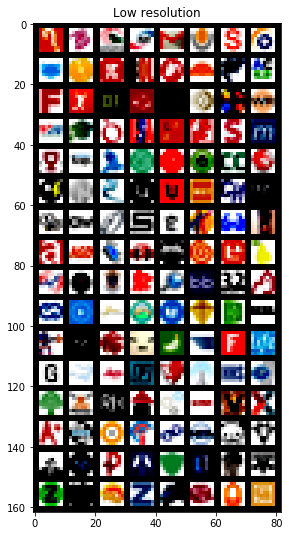

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


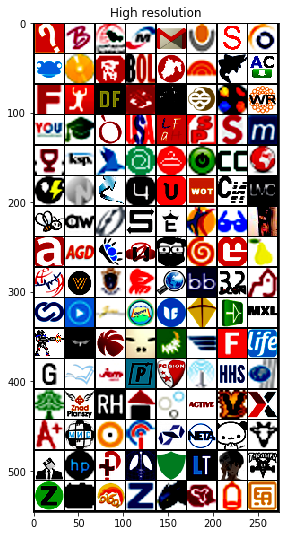

In [5]:
# Lets see some examples
loader=iter(train_loader)
low_batch, high_batch=next(loader)
grid = torchvision.utils.make_grid(low_batch)
npimg = grid.numpy()
plt.figure(figsize=(9,9))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.title("Low resolution")
plt.show()
plt.figure(figsize=(9,9))
grid = torchvision.utils.make_grid(high_batch)
npimg = grid.numpy()
plt.title("High resolution")
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.show()

# Implement the Discriminator Architecture of your Design

Use Conv2d, Linear and Activation Layers to design a Discriminator

Please note: Pay attention to whether Sigmoid Unit at the last layer is added in the Architecture OR in the Loss function, because in implementations of some loss functions in Pytorch, sigmoid unit is included by default. In this notebook we use BCELoss (given default) so you should add sigmoid to last layer.

Different than normal GAN, you need to use conditional GAN approach so you should feed (lowres image, generated) and (lowres image, groundtruth) concatenated channel wise.

In [6]:
discriminator_filter_size = 128
generator_filter_size = 128

# My GAN network is similar to the DCGAN one of the earliest convolutional GAN architectures
# But in my GAN network latent space dimension is bigger than the DCGAN which empowers the model
# by containing more information as a latent space.
# Training process of the discriminator and generator considers the points that DCGAN authors defined.

# DC Gan proposes weight initialization from 0.02 Gaussian distribution
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [7]:
class Discriminator(torch.nn.Module):
    """
    Implement discriminator network
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, discriminator_filter_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size, discriminator_filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 2, discriminator_filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 4, discriminator_filter_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        """
        Implement forward-pass
        """
        x = self.main(x)
        
        return x

In [8]:
discriminator = Discriminator()
# As DC GAN paper propose we initialize weights from small gaussian distribution
discriminator.apply(weights_init)
discriminator = discriminator.cuda()

# Implement the Generator Architecture of your Design

You can use (Upsample, Conv2d) pair or ConvTranspose2d and Activation Layers to design a Generator. Add Tanh to last layer for better training.

Different than normal GAN, again for conditional GAN approach you should give low res image as input to generator instead of random noise


In [9]:
#output_size = strides * (input_size-1) + kernel_size - 2*padding
output_size = 1 * (32-1) + 3 - 2*1
print(output_size)

32


In [10]:
class Generator(torch.nn.Module):
    """
    Implement Generator Network
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 3, generator_filter_size * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(generator_filter_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 8, generator_filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_filter_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 4, generator_filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_filter_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 2, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        """
        Implement forward-pass
        """
        x = self.main(x)
        return x

In [11]:
generator = Generator()
generator.apply(weights_init)
generator = generator.cuda()

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [12]:
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-3)

# Super Resolution GAN combines Binary Cross Entropy loss and Mean Squared Error loss, instatiated below.

In [13]:
adv_loss = nn.BCELoss()
rec_loss = nn.MSELoss()

# Implement train and validation code below. Calculate Average PSNR for validation set.

In [14]:
from math import log10
num_epochs = 10
losses_iter_discriminator = []
losses_epoch_discriminator = []
losses_iter_generator = []
losses_epoch_generator = []
losses_validation = []
avg_psnr_list = []
generator.train()
discriminator.train()
real_label = 1
fake_label = 0
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    count = 0
    for n_batch, (x_low, x) in enumerate(train_loader):
        
        x_low = x_low.cuda()
        x = x.cuda()
        
        # Adversarial ground truths
        valid = torch.full((x_low.size(0), 1,1,1), real_label).cuda()
        fake = torch.full((x_low.size(0), 1,1,1), fake_label).cuda()
        # ------------------
        #  Train Generator
        # ------------------

        gen_optimizer.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(x_low)
        
        # Adversarial loss
        loss_GAN = adv_loss(discriminator(gen_hr), valid)

        # Content loss
        loss_content = rec_loss(gen_hr, x)
        
        # Total loss
        # This hyper parameter can be changed for sharper images 
        loss_G = loss_content + 2e-1 * loss_GAN
        losses_iter_generator.append(loss_G.item())
        loss_G.backward()
        gen_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        disc_optimizer.zero_grad()

        # Loss of real and fake images
        loss_real = adv_loss(discriminator(x), valid)
        loss_fake = adv_loss(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        losses_iter_discriminator.append(loss_D.item())
        loss_D.backward()
        disc_optimizer.step()
        
        
        if (n_batch + 1) % 100 == 0:
            print("epoch: {%d}, batch number: {%d}, d_error: {%.4f}, g_error: {%.4f}" % 
                  (epoch + 1, n_batch + 1, loss_D.item(), loss_G.item()))
    losses_epoch_discriminator.append(np.mean(losses_iter_discriminator[-count:]))
    losses_epoch_generator.append(np.mean(losses_iter_generator[-count:]))
    ### VALIDATION PHASE ###
    generator.eval()
    with torch.no_grad():
        avg_psnr = 0
        val_iter_loss = 0
        for n_batch, (x_low, x) in enumerate(val_loader):
            x_low = x_low.cuda()
            x = x.cuda()
            x_reconstruction = generator(x_low)
            loss_content = rec_loss(x_reconstruction, x)
            val_iter_loss += loss_content.item()
            psnr = 10 * log10(1 / loss_content.item())
            avg_psnr += psnr
        losses_validation.append(val_iter_loss/len(val_loader))
        avg_psnr_list.append(avg_psnr / len(val_loader))
        print("VALIDATION ====> epoch: {} Avg. PSNR: {:.4f} dB".format(epoch+1,avg_psnr_list[-1]))
        print("VALIDATION ====> epoch: {} val_error: {:.4f}".format(epoch+1,losses_validation[-1]))

epoch: {1}, batch number: {100}, d_error: {0.4866}, g_error: {0.0631}
epoch: {1}, batch number: {200}, d_error: {0.2322}, g_error: {0.0649}
epoch: {1}, batch number: {300}, d_error: {0.0709}, g_error: {0.0711}
epoch: {1}, batch number: {400}, d_error: {0.0889}, g_error: {0.0697}
epoch: {1}, batch number: {500}, d_error: {0.1963}, g_error: {0.0617}
epoch: {1}, batch number: {600}, d_error: {0.0097}, g_error: {0.0749}
epoch: {1}, batch number: {700}, d_error: {0.0030}, g_error: {0.0707}
epoch: {1}, batch number: {800}, d_error: {0.0470}, g_error: {0.0622}
epoch: {1}, batch number: {900}, d_error: {0.1740}, g_error: {0.0582}
epoch: {1}, batch number: {1000}, d_error: {0.4068}, g_error: {0.0586}
epoch: {1}, batch number: {1100}, d_error: {0.0176}, g_error: {0.0690}
epoch: {1}, batch number: {1200}, d_error: {0.3868}, g_error: {0.0613}
epoch: {1}, batch number: {1300}, d_error: {0.1749}, g_error: {0.0540}
epoch: {1}, batch number: {1400}, d_error: {0.2199}, g_error: {0.0634}
epoch: {1}, bat

epoch: {4}, batch number: {2100}, d_error: {0.0003}, g_error: {0.0685}
epoch: {4}, batch number: {2200}, d_error: {0.0146}, g_error: {0.0611}
epoch: {4}, batch number: {2300}, d_error: {0.0001}, g_error: {0.0729}
epoch: {4}, batch number: {2400}, d_error: {0.0333}, g_error: {0.0672}
epoch: {4}, batch number: {2500}, d_error: {0.0300}, g_error: {0.0694}
epoch: {4}, batch number: {2600}, d_error: {0.0019}, g_error: {0.0709}
epoch: {4}, batch number: {2700}, d_error: {0.0097}, g_error: {0.0698}
epoch: {4}, batch number: {2800}, d_error: {0.0030}, g_error: {0.0673}
epoch: {4}, batch number: {2900}, d_error: {0.0017}, g_error: {0.0701}
epoch: {4}, batch number: {3000}, d_error: {0.0489}, g_error: {0.0638}
epoch: {4}, batch number: {3100}, d_error: {0.0507}, g_error: {0.0563}
VALIDATION ====> epoch: 4 Avg. PSNR: 12.4563 dB
VALIDATION ====> epoch: 4 val_error: 0.0570
epoch: {5}, batch number: {100}, d_error: {0.1446}, g_error: {0.0606}
epoch: {5}, batch number: {200}, d_error: {0.0043}, g_err

epoch: {8}, batch number: {800}, d_error: {0.0051}, g_error: {0.0716}
epoch: {8}, batch number: {900}, d_error: {0.0975}, g_error: {0.0670}
epoch: {8}, batch number: {1000}, d_error: {0.0003}, g_error: {0.0751}
epoch: {8}, batch number: {1100}, d_error: {0.0001}, g_error: {0.0712}
epoch: {8}, batch number: {1200}, d_error: {0.0024}, g_error: {0.0705}
epoch: {8}, batch number: {1300}, d_error: {0.0000}, g_error: {0.0799}
epoch: {8}, batch number: {1400}, d_error: {0.0033}, g_error: {0.0659}
epoch: {8}, batch number: {1500}, d_error: {0.0001}, g_error: {0.0717}
epoch: {8}, batch number: {1600}, d_error: {0.0001}, g_error: {0.0737}
epoch: {8}, batch number: {1700}, d_error: {0.0000}, g_error: {0.0672}
epoch: {8}, batch number: {1800}, d_error: {0.0025}, g_error: {0.0708}
epoch: {8}, batch number: {1900}, d_error: {0.0017}, g_error: {0.0640}
epoch: {8}, batch number: {2000}, d_error: {0.0594}, g_error: {0.0687}
epoch: {8}, batch number: {2100}, d_error: {0.0001}, g_error: {0.0639}
epoch: {

## Report the training loss curves and test results (generated images) of your model. Also briefly discuss the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


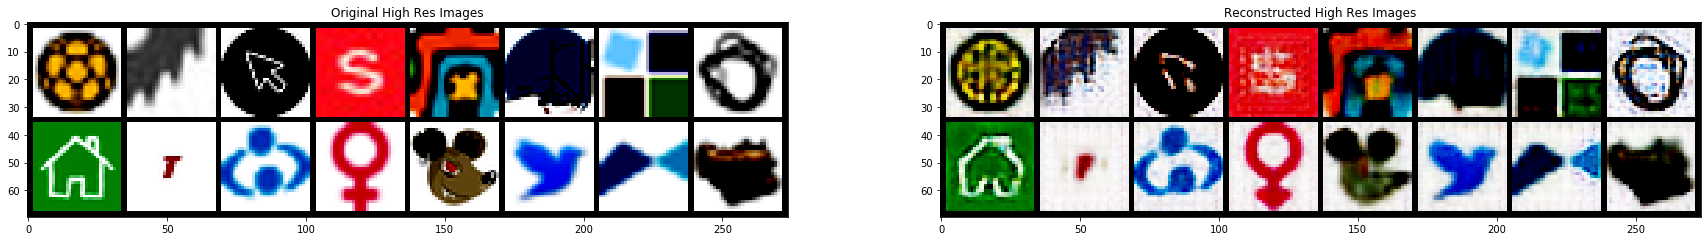

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


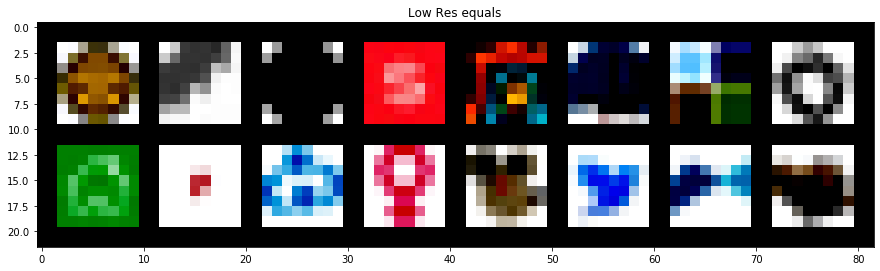

In [15]:
import torchvision.utils as vutils
# Reconstruct high res images by using low res
generator.eval()
iter_loader = iter(test_loader)
batch_low, batch = next(iter_loader)
batch_low = batch_low.cuda()
reconstructed = generator(batch_low)

reconstructed = reconstructed.cpu().detach()
batch_low = batch_low.cpu().detach()
fig, ax = plt.subplots(1,2,figsize=(30,30))
batch_reconstructed_output_grid = torchvision.utils.make_grid(reconstructed[:16]).numpy()
batch_original_grid = torchvision.utils.make_grid(batch[:16]).numpy()
batch_low_grid = torchvision.utils.make_grid(batch_low[:16]).numpy()

ax[0].imshow(np.transpose(batch_original_grid, (1, 2, 0)))
ax[0].set_title('Original High Res Images')
ax[1].imshow(np.transpose(batch_reconstructed_output_grid, (1, 2, 0)))
ax[1].set_title('Reconstructed High Res Images')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(batch_low_grid, (1, 2, 0)))
plt.title("Low Res equals")
plt.show()

**As you can see the result on the top model is able to reconstruct the unseen logos very succesfully. There are some blurs and letters are mostly lost but it is a shallow model and therefore it is expected to be like that.**

**Yet there is a little error in the PSNR plots and it makes me suspicious about the training process because PSNR value sometimes decrease and sometimes increase. This trend shows that something is wrong. But overall model works pretty good, it just need more sharpness on the edges (e.g red logo that contains S is not clear in the reconstruction but twitter bird is sharp and clear) but color and overall structure reconstruction is very succesful.**

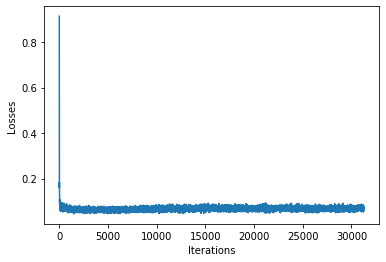

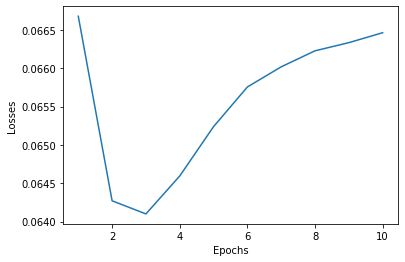

In [21]:
# Plot Generator Loss
plt.figure()
plt.plot([i+1 for i in range(len(losses_iter_generator))],losses_iter_generator)
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.show()

plt.figure()
plt.plot([i+1 for i in range(len(losses_epoch_generator))],losses_epoch_generator)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

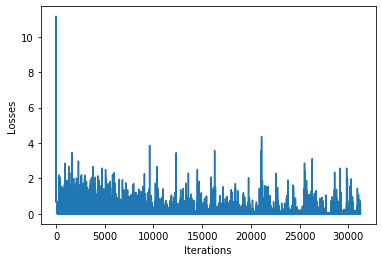

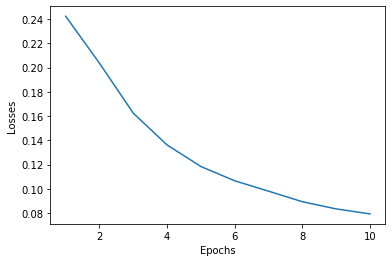

In [22]:
# Plot Discriminator Loss
plt.figure()
plt.plot([i+1 for i in range(len(losses_iter_discriminator))],losses_iter_discriminator)
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.show()

plt.figure()
plt.plot([i+1 for i in range(len(losses_epoch_discriminator))],losses_epoch_discriminator)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

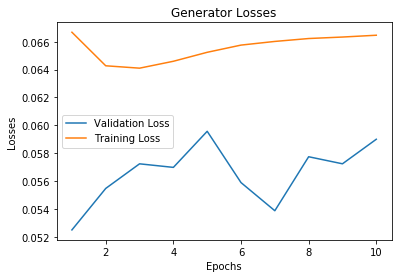

In [23]:
# Plot Validation Loss vs Train loss  of Generator
plt.figure()
plt.plot([i+1 for i in range(len(losses_validation))],losses_validation,label="Validation Loss")
plt.plot([i+1 for i in range(len(losses_epoch_generator))],losses_epoch_generator,label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Generator Losses")
plt.legend()
plt.show()

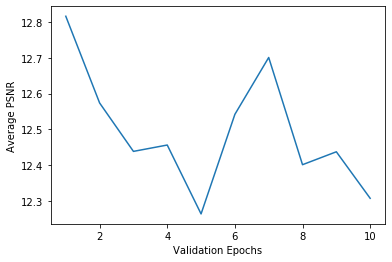

In [24]:
# PSNR Values of the validations
plt.figure()
plt.plot([i+1 for i in range(len(avg_psnr_list))],avg_psnr_list)
plt.xlabel("Validation Epochs")
plt.ylabel("Average PSNR")
plt.show()

#### After you have completed the training, save your generator model using the following command
**Model weight link= https://drive.google.com/open?id=1xlpYBD99gBVex71ai1bhS-2ES1DLxbXn**

In [25]:
student_id = 504191504
torch.save(generator.state_dict(),'{}_SR.pth'.format(student_id))